# Importando bibliotecas

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ["SM_FRAMEWORK"] ="tf.keras"

import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
import segmentation_models as sm    

2023-11-03 05:07:35.531066: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-03 05:07:35.531109: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-03 05:07:35.531130: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-03 05:07:35.538039: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Segmentation Models: using `tf.keras` framework.


# Definindo funcoes e classes auxiliares

In [2]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)   

# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['car','wheel','light','windows']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image,dsize=(128,128),interpolation=cv2.INTER_AREA)
        mask = cv2.imread(self.masks_fps[i], 0)
        mask = cv2.resize(mask,dsize=(128,128),interpolation=cv2.INTER_AREA)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)   

In [3]:
x_train_dir = "./../../Datasets/Exercicio_Segmentacao/train/images/"
y_train_dir = "./../../Datasets/Exercicio_Segmentacao/train/masks/"

x_valid_dir = "./../../Datasets/Exercicio_Segmentacao/valid/images/"
y_valid_dir = "./../../Datasets/Exercicio_Segmentacao/valid/masks/"

x_test_dir = "./../../Datasets/Exercicio_Segmentacao/test/images/"
y_test_dir = "./../../Datasets/Exercicio_Segmentacao/test/masks/"

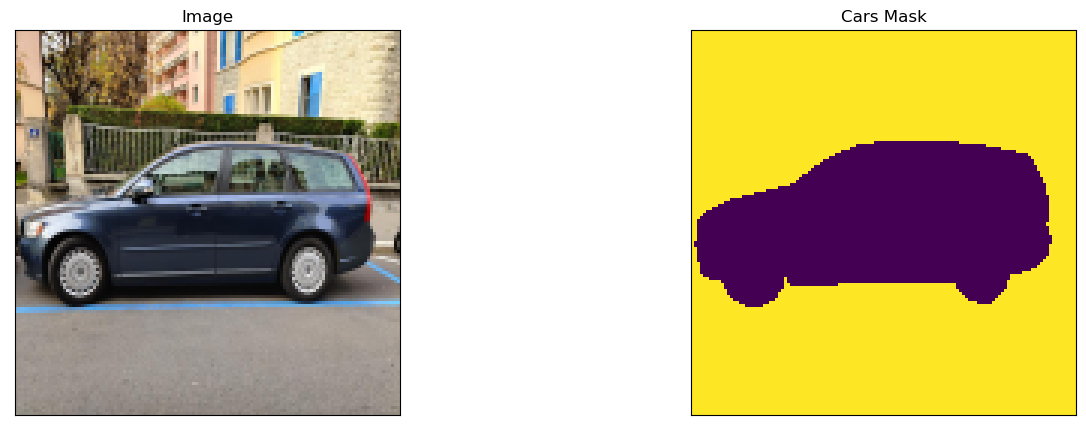

In [4]:
# Lets look at data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['car'])

image, mask = dataset[5] # get some sample
visualize(
    image=image, 
    cars_mask=mask[..., 0].squeeze(),
    # sky_mask=mask[..., 1].squeeze(),
    # background_mask=mask[..., 2].squeeze(),
)

# Definindo parametros do modelo

In [5]:
BACKBONE = 'resnet18'
BATCH_SIZE = 2
CLASSES = ['car']
LR = 0.0001
EPOCHS = 10

preprocess_input = sm.get_preprocessing(BACKBONE)

In [6]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

2023-11-03 05:07:38.573472: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-03 05:07:38.580245: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-03 05:07:38.580638: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

# Definindo métricas e otimizador

In [7]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()

total_loss = sm.losses.binary_focal_dice_loss if n_classes == 1 else sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

# Instanciando dataset

In [8]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    # augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    # augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
# assert train_dataloader[0][0].shape == (BATCH_SIZE, 320, 320, 3)
# assert train_dataloader[0][1].shape == (BATCH_SIZE, 320, 320, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

# Treinando o modelo

In [9]:
"""

exiftool -ICC_Profile=./Exercicio_Segmentacao/


"""

# train model
history = model.fit(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/10


2023-11-03 05:07:49.983378: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-03 05:07:50.028161: W tensorflow/compiler/mlir/tools/kernel_gen/tf_gpu_runtime_wrappers.cc:30] 'cuModuleLoadData(&module, data)' failed with 'CUDA_ERROR_INVALID_IMAGE'

2023-11-03 05:07:50.028188: W tensorflow/compiler/mlir/tools/kernel_gen/tf_gpu_runtime_wrappers.cc:30] 'cuModuleGetFunction(&function, module, kernel_name)' failed with 'CUDA_ERROR_INVALID_HANDLE'

2023-11-03 05:07:50.028196: W tensorflow/core/framework/op_kernel.cc:1827] INTERNAL: 'cuLaunchKernel(function, gridX, gridY, gridZ, blockX, blockY, blockZ, 0, reinterpret_cast<CUstream>(stream), params, nullptr)' failed with 'CUDA_ERROR_INVALID_HANDLE'
2023-11-03 05:07:50.028251: W tensorflow/compiler/mlir/tools/kernel_gen/tf_gpu_runtime_wrappers.cc:30] 'cuModuleLoadData(&module, data)' failed with 'CUDA_ERROR_INVALID_IMAGE'

2023-11-03 05:07:50.028267: W tensorflow/compiler/mlir

InternalError: Graph execution error:

Detected at node binary_focal_loss_plus_dice_loss/Neg defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/home/pablo_veinberg/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/pablo_veinberg/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 1041, in launch_instance

  File "/home/pablo_veinberg/.local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 724, in start

  File "/home/pablo_veinberg/.local/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/home/pablo_veinberg/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue

  File "/home/pablo_veinberg/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 501, in process_one

  File "/home/pablo_veinberg/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell

  File "/home/pablo_veinberg/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 731, in execute_request

  File "/home/pablo_veinberg/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 417, in do_execute

  File "/home/pablo_veinberg/.local/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 540, in run_cell

  File "/home/pablo_veinberg/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2945, in run_cell

  File "/home/pablo_veinberg/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3000, in _run_cell

  File "/home/pablo_veinberg/.local/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/pablo_veinberg/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3203, in run_cell_async

  File "/home/pablo_veinberg/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3382, in run_ast_nodes

  File "/home/pablo_veinberg/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3442, in run_code

  File "/tmp/ipykernel_10887/4247372138.py", line 9, in <module>

  File "/home/pablo_veinberg/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/pablo_veinberg/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1783, in fit

  File "/home/pablo_veinberg/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1377, in train_function

  File "/home/pablo_veinberg/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1360, in step_function

  File "/home/pablo_veinberg/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1349, in run_step

  File "/home/pablo_veinberg/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1127, in train_step

  File "/home/pablo_veinberg/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1185, in compute_loss

  File "/home/pablo_veinberg/.local/lib/python3.10/site-packages/keras/src/engine/compile_utils.py", line 277, in __call__

  File "/home/pablo_veinberg/.local/lib/python3.10/site-packages/keras/src/losses.py", line 143, in __call__

  File "/home/pablo_veinberg/.local/lib/python3.10/site-packages/keras/src/losses.py", line 270, in call

  File "/home/pablo_veinberg/.local/lib/python3.10/site-packages/segmentation_models/base/objects.py", line 114, in __call__

  File "/home/pablo_veinberg/.local/lib/python3.10/site-packages/segmentation_models/losses.py", line 238, in __call__

  File "/home/pablo_veinberg/.local/lib/python3.10/site-packages/segmentation_models/base/functional.py", line 304, in binary_focal_loss

'cuLaunchKernel(function, gridX, gridY, gridZ, blockX, blockY, blockZ, 0, reinterpret_cast<CUstream>(stream), params, nullptr)' failed with 'CUDA_ERROR_INVALID_HANDLE'
	 [[{{node binary_focal_loss_plus_dice_loss/Neg}}]] [Op:__inference_train_function_12002]

# Visualizando resultados do treino

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


# Instanciando teste

In [ ]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    # augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

In [ ]:
# load best weights
model.load_weights('best_model.h5') 

In [ ]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

# Visualizando alguns testes

In [ ]:
n = 5
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image)
    
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask.squeeze(),
        pr_mask=pr_mask.squeeze(),
    )